In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scipy
import os
import scipy.io as sio


In [2]:
adata1 = sc.read_h5ad("adata/iGlut_post_p1_filtered_doublets.h5ad")
adata2 = sc.read_h5ad("adata/iGlut_post_p2_filtered_doublets.h5ad")

In [3]:
adata1.var_names_make_unique()
adata1.obs['sample'] = 'iGlut_post_p1'

adata2.var_names_make_unique()
adata2.obs['sample'] = 'iGlut_post_p2'


In [4]:
adata = sc.concat([adata1,adata2])
adata.obs_names_make_unique()

/links/groups/treutlein/USERS/jjans/anaconda3/envs/py_jjans_3.10_scanpy/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


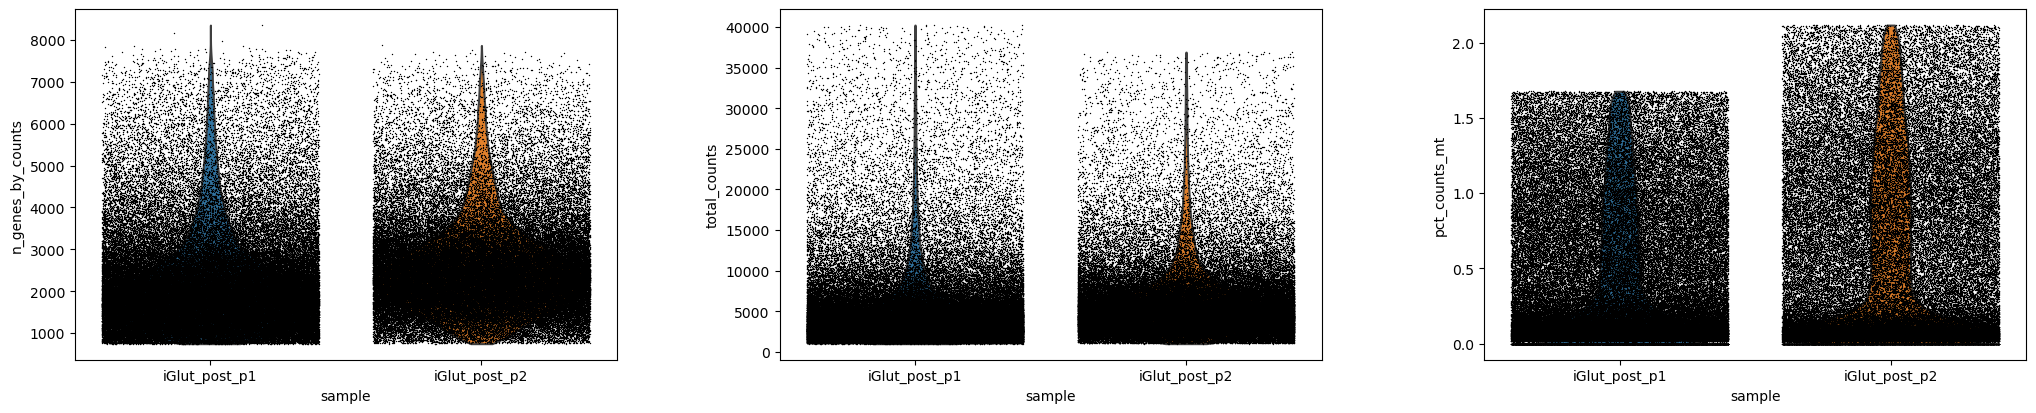

In [5]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],groupby='sample',
             jitter=0.4, multi_panel=True)


In [6]:
sc.pp.filter_genes(adata, min_cells=3)
adata.raw = adata
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable]
sc.pp.regress_out(adata, ['total_counts']) #had a big effect in first clustering
sc.pp.scale(adata, max_value=10)

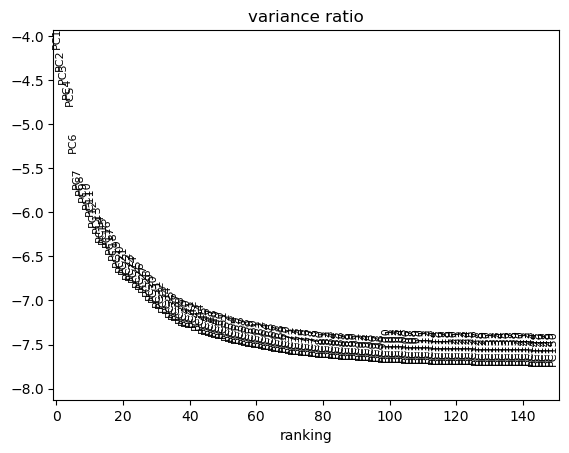

In [7]:
sc.tl.pca(adata, svd_solver='arpack',n_comps=150)
sc.pl.pca_variance_ratio(adata, log=True,n_pcs=150)

In [8]:
adata.write_h5ad("scanpy/iGlut_post_scaled.h5ad")

In [2]:
adata = sc.read_h5ad("scanpy/iGlut_post_harmony.h5ad")

In [4]:
from threadpoolctl import threadpool_limits
with threadpool_limits(limits=50, user_api='blas'):
    sc.pp.neighbors(adata, n_neighbors=30, n_pcs=60)
    sc.tl.umap(adata)
    sc.tl.tsne(adata)

In [5]:
adata.write_h5ad("scanpy/iGlut_post_dr.h5ad")

In [6]:
sc.tl.leiden(adata,resolution=4,key_added='leiden_4')
sc.tl.leiden(adata,resolution=10,key_added='leiden_10')


In [7]:
adata.write_h5ad("scanpy/iGlut_post_dr_clustered.h5ad")

In [8]:
adata1 = sc.read_h5ad("adata/iGlut_post_p1_filtered_doublets.h5ad")
adata2 = sc.read_h5ad("adata/iGlut_post_p2_filtered_doublets.h5ad")

adata1.var_names_make_unique()
adata1.obs['sample'] = 'iGlut_post_p1'

adata2.var_names_make_unique()
adata2.obs['sample'] = 'iGlut_post_p2'

adata_raw = sc.concat([adata1,adata2])
adata_raw.obs_names_make_unique()

/links/groups/treutlein/USERS/jjans/anaconda3/envs/py_jjans_3.10_scanpy/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [9]:
adata_raw.obs = adata.obs
adata_raw.obsm = adata.obsm
adata_raw.obsp = adata.obsp

In [10]:
adata_raw.write_h5ad("scanpy/iGlut_post_dr_clustered_raw.h5ad")

In [ ]:
# Load gene lists
ion_channels = pd.read_csv("/home/jjanssens/jjans/resources/geneLists/HGNC/human_ion_channels.txt", sep="\t")['Approved symbol'].unique()
tfs = pd.read_csv("/home/jjanssens/jjans/resources/resources.aertslab.org/cistarget/tf_lists/allTFs_hg38.txt", sep="\t", header=None)[0].unique()
info_genes = list(set(ion_channels) | set(tfs))

from clustering_functions import *

In [12]:
adata_raw = merge_clusters_adata(adata_raw,base_resolution='leiden_10',max_iter=20)
adata.obs['merged_clusters_from_10'] = adata.obs['merged_clusters']

1
calculating DEGs


  0%|          | 0/112 [00:00<?, ?it/s]

calculating cluster summaries
merging clusters
2
calculating DEGs


  0%|          | 0/104 [00:00<?, ?it/s]

calculating cluster summaries
merging clusters
3
calculating DEGs


  0%|          | 0/101 [00:00<?, ?it/s]

calculating cluster summaries
merging clusters
number of iterations needed 3
original number of clusters 112
merged number of clusters 101


In [13]:
adata_raw.write_h5ad("scanpy/iGlut_post_dr_clustered_raw_merged.h5ad")

In [14]:
adata_raw

AnnData object with n_obs × n_vars = 184431 × 62710
    obs: 'sample', 'species', 'gene_count', 'tscp_count', 'mread_count', 'bc1_well', 'bc2_well', 'bc3_well', 'bc1_wind', 'bc2_wind', 'bc3_wind', 'plateID', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'n_genes', 'percent_mito', 'n_counts', 'outlier', 'mt_outlier', 'doublet_score', 'predicted_doublet', 'leiden_4', 'leiden_10', 'merged_clusters', 'final_clustering', 'final_clustering_reset', 'merged_clusters_from_10'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap', 'X_tsne'
    obsp: 'distances', 'connectivities'

In [15]:
adata_raw.obs['merged_clusters_from_10'].value_counts()

91    11523
32    10304
64     7383
99     5581
2      4152
      ...  
47      194
77      165
56      125
39      112
49       17
Name: merged_clusters_from_10, Length: 101, dtype: int64

In [16]:
import matplotlib as mpl
import matplotlib.pyplot as plt

/links/groups/treutlein/USERS/jjans/anaconda3/envs/py_jjans_3.10_scanpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/links/groups/treutlein/USERS/jjans/anaconda3/envs/py_jjans_3.10_scanpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/links/groups/treutlein/USERS/jjans/anaconda3/envs/py_jjans_3.10_scanpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


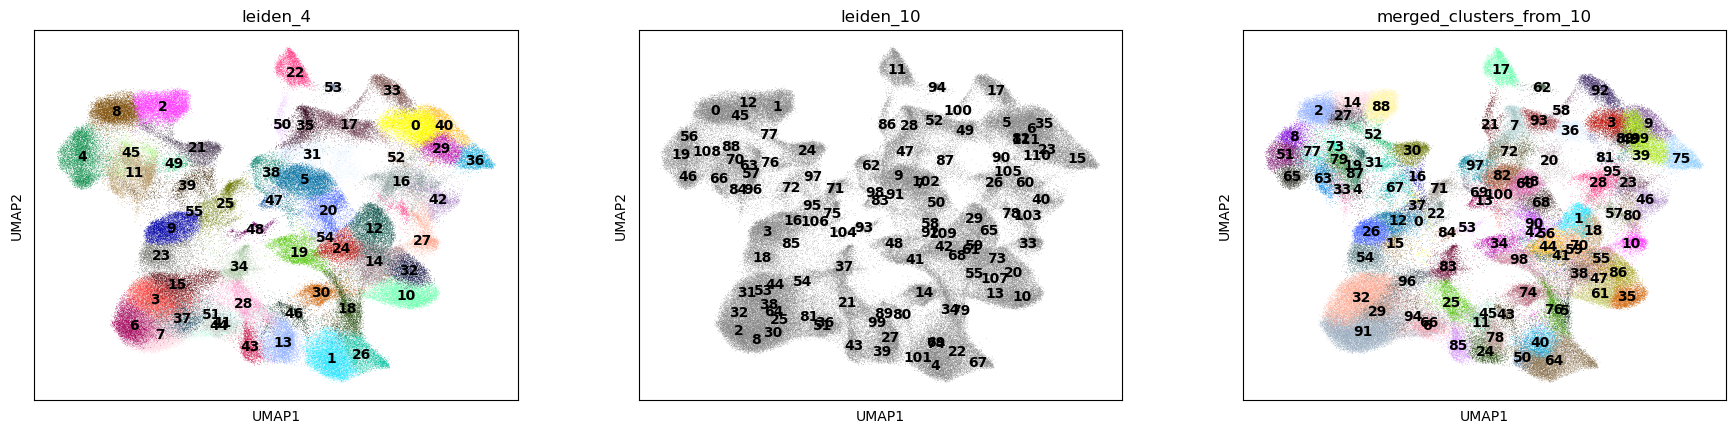

In [17]:
sc.pl.umap(adata_raw,color=['leiden_4','leiden_10','merged_clusters_from_10'],legend_loc='on data')
plt.show()
plt.close()

/links/groups/treutlein/USERS/jjans/anaconda3/envs/py_jjans_3.10_scanpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/links/groups/treutlein/USERS/jjans/anaconda3/envs/py_jjans_3.10_scanpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/links/groups/treutlein/USERS/jjans/anaconda3/envs/py_jjans_3.10_scanpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


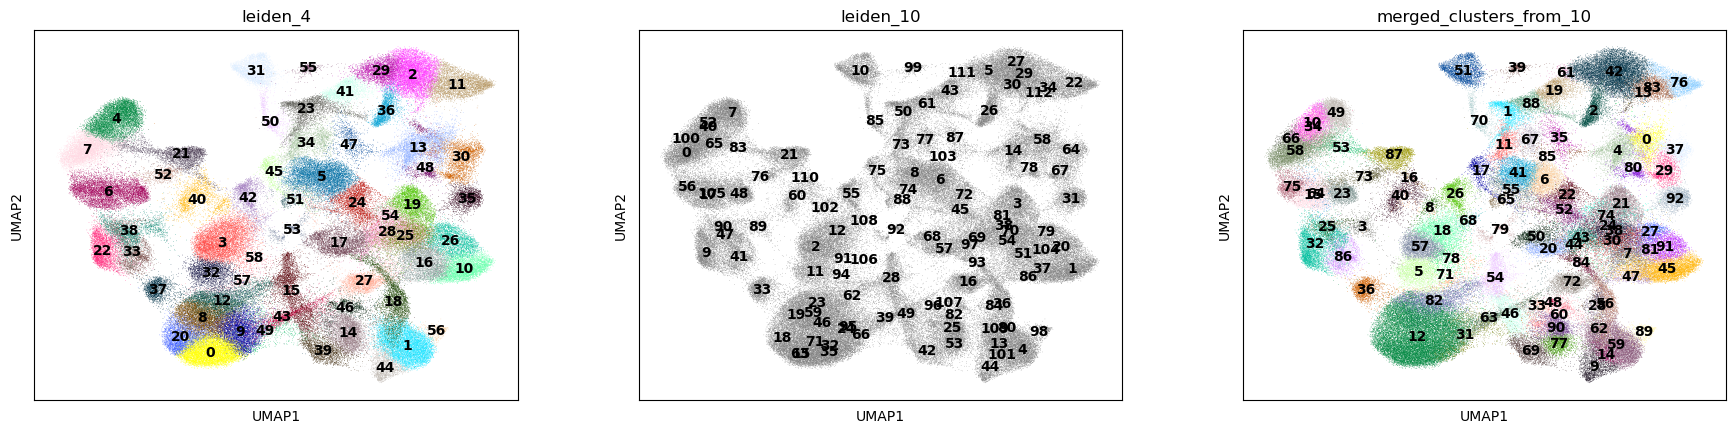

In [39]:
sc.pl.umap(adata_raw,color=['leiden_4','leiden_10','merged_clusters_from_10'],legend_loc='on data')
plt.show()
plt.close()

/links/groups/treutlein/USERS/jjans/anaconda3/envs/py_jjans_3.10_scanpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


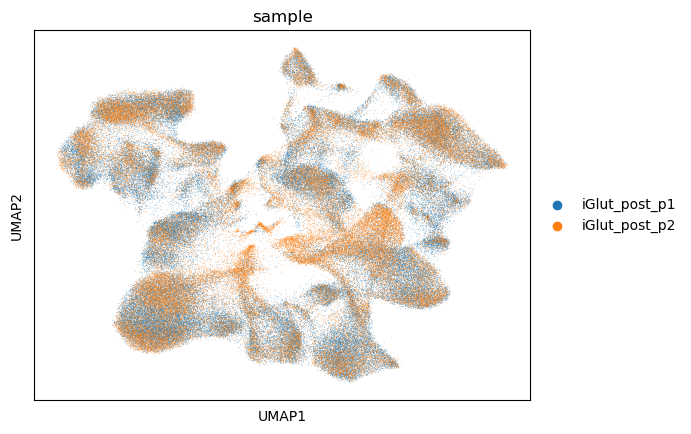

In [18]:
sc.pl.umap(adata_raw,color=['sample'])
plt.show()
plt.close()

In [ ]:
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=80)
sc.tl.umap(adata)
